In [1]:
import sys
import os.path
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import h5py

In [2]:
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

In [3]:
def set_simulation(base_url,sim_name):
    # Select the simulation specified by the user
    r = get(base_url)
    names = [sim['name'] for sim in r['simulations']]
    if sim_name in names:
        i = names.index(sim_name)
        sim = get( r['simulations'][i]['url'] )
        print("Box size = %f kpc/h"%sim["boxsize"])
        print("DM particle mass = %f x 1e10 Msun/h"%sim["mass_dm"])
        print("Gas particle mass = %f x 1e10 Msun/h"%sim["mass_gas"])
        return sim
    else:
        print "The selected simulation name doesn't exist!!!"
        sys.exit()

In [4]:
def set_redshift(snap_url,sim_z):
    # Find the appropriate snapshot for the selected redshift
    isnap = len(snaps)-1
    while sim_z >= snaps[isnap]["redshift"]:
        isnap -= 1
    return isnap, snaps[isnap]["number"], snaps[isnap]["redshift"]

In [5]:
def get_subhalos(snap,mass_min,mass_max,vmax,lim):
    # Select subhalos with given requirements
    subs = get(snap["subhalos"], {"limit" : lim})
    # Set a stellar mass range and maximum circular velocity
    search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max) + "&vmax__gt=" + str(vmax)
    search_url = snap["url"]+"/subhalos/"+search_query
    subhalos = get(search_url, {"limit" : lim})
    return subhalos

In [6]:
def make_projected_prof(cutout_hdf5,ptype_dic,rc,proj_axis,rmin,rmax,nbins,mdmpart):
    # This function makes mass density profiles useful for gravitational lensing studies.
    
    # Initialize profile
    nvars = int(1+3*len(ptype_dic.keys()))
    shape = (nbins,nvars)
    projected_prof = np.zeros(shape)
    iprof_dic = {"dm":1,"gas":2,"stars":3,"bhs":4}
    
    # Radial Bins
    rmin = np.log10(rmin)
    rmax = np.log10(rmax)
    dlogr = (rmax-rmin)/float(nbins)
    for i in range(0,nbins):
        projected_prof[i,0] = rmin + 0.5*dlogr + float(i)*dlogr
        for ptype in ptype_dic.keys():
            with h5py.File(cutout_hdf5,'r') as f:
                rnorm = np.array([(f['PartType'+ptype_dic[ptype]]['Coordinates'][:,0]-rc[0])*proj_axis[0], \
                                  (f['PartType'+ptype_dic[ptype]]['Coordinates'][:,1]-rc[1])*proj_axis[1], \
                                  (f['PartType'+ptype_dic[ptype]]['Coordinates'][:,2]-rc[2])*proj_axis[2]])
                rnorm = rnorm.T
                rproj = np.sqrt((f['PartType'+ptype_dic[ptype]]['Coordinates'][:,0]-rc[0]-rnorm[:,0])**2+ \
                                (f['PartType'+ptype_dic[ptype]]['Coordinates'][:,1]-rc[1]-rnorm[:,1])**2+ \
                                (f['PartType'+ptype_dic[ptype]]['Coordinates'][:,2]-rc[2]-rnorm[:,2])**2)
                rproj = np.log10(rproj)
                del rnorm
                try :
                    mass = f['PartType'+ptype_dic[ptype]]['Masses'][:]
                except :
                    #print("Particle type %s does not exist for halo %d"%(ptype,idsub))
                    mass = np.array(len(rproj[:])*[mdmpart])
                
                # Surface densities in bins
                for i in range(0,nbins):
                    #print 'bin ',i, iprof_dic[ptype]
                    ishell = np.logical_and(projected_prof[i,0]-0.5*dlogr < rproj, rproj <= projected_prof[i,0]+0.5*dlogr)
                    icum = rproj <= projected_prof[i,0]
                    shell = np.pi*(10**(2*(projected_prof[i,0]+0.5*dlogr))-10**(2*(projected_prof[i,0]-0.5*dlogr)))*1e6 # (pc/h)**2
                    surf = np.pi*(10**(2*projected_prof[i,0]))*1e6 # (pc/h)**2
                    ivar = iprof_dic[ptype]
                    projected_prof[i,ivar] = np.sum(mass[icum])*1e10/surf # Msun/h/(pc/h)**2
                    projected_prof[i,ivar+len(ptype_dic.keys())] = np.sum(mass[ishell])*1e10/shell # Msun/h/(pc/h)**2
                    projected_prof[i,ivar+2*len(ptype_dic.keys())] = projected_prof[i,ivar] - projected_prof[i,ivar+len(ptype_dic.keys())]

                del rproj,mass,ishell,icum
        
    return projected_prof 

In [7]:
# Input parameters 
# Select simulation and redshift 
sim_name = "Illustris-3" ## Name of the simulation
sim_z = 0.0 ## Redshift of the snapshot
mass_min = 1.0e11 / 1e10 / 0.6774 ## Minimum stellar mass in 1e10 Msun/h
mass_max = 1.0e13 / 1e10 / 0.6774 ## Maximum stellar mass in 1e10 Msun/h
vmax = 350 # Vmax cutoff in km/s
lim = 1000 ## Maximum number of subhalos in list

In [8]:
# read API key
if os.path.exists('.api_key'):
    api_key = np.loadtxt('.api_key',dtype="S50")
    api_key = str(api_key)
elif os.path.exists('~/.api_key'):
    api_key = np.loadtxt('~/.api_key',dtype="S50")
    api_key = str(api_key)
else:
    print "Please, create file .api_key with your API key."
    sys.exit()

In [9]:
# URL to the API
base_url = "http://www.tng-project.org/api/"
headers = {"api-key": api_key}

# Select the simulation
print("Reading %s simulation."%sim_name)
sim = set_simulation(base_url,sim_name)

# Dark matter particle mass
mdmpart = sim["mass_dm"]
    
# List of simulation snapshots
snaps = get( sim["snapshots"] )
    
# Find the appropriate snapshot for the selected redshift
snap_url = sim["snapshots"]
isnap, inumber, snap_z = set_redshift(snap_url,sim_z)
snap = get(snaps[isnap]["url"])
print("Selecting snapshot number %d at redshift z = %e."%(inumber,snap_z))

Reading Illustris-3 simulation.
Box size = 75000.000000 kpc/h
DM particle mass = 0.028217 x 1e10 Msun/h
Gas particle mass = 0.005668 x 1e10 Msun/h
Selecting snapshot number 135 at redshift z = 2.220446e-16.


In [10]:
# Get subhalos in a given stellar mass range 
subhalos = get_subhalos(snap,mass_min,mass_max,vmax,lim)
nselected = subhalos["count"]
print("# of selected subhalos with %f < log10(Mstar) < %f = %d."%(np.log10(1e10*mass_min*0.6774),np.log10(1e10*mass_max*0.6774),nselected))
# Subhalo ids
ids = [ subhalos['results'][i]['id'] for i in range(0,len(subhalos['results'][:])) ]

# of selected subhalos with 11.000000 < log10(Mstar) < 13.000000 = 57.


In [11]:
# Loop on all selected subhalo ids
flag = 0
cutout_dic = {}
for idsub in ids:
    sub_url = snap["url"]+"/subhalos/"+str(idsub)
    subhalo = get(sub_url)
    # If you want the subhalo cutout
    #cutout_url = subhalo["cutouts"]["subhalo"]
    # If you want the parent halo cutout
    cutout_url = subhalo["cutouts"]["parent_halo"]

    # Subhalo center
    rc = np.array([subhalo["pos_x"], subhalo["pos_y"], subhalo["pos_z"]])

    cutout_exists = os.path.isfile('cutout_'+str(subhalo["grnr"])+'.hdf5')
    if cutout_exists:
        cutout_dic[subhalo["grnr"]] = 'cutout_'+str(subhalo["grnr"])+'.hdf5'
        
    if subhalo["grnr"] not in cutout_dic.keys():
        cutout_request = {'gas':'Coordinates,Masses','stars':'Coordinates,Masses','dm':'Coordinates','bhs':'Coordinates,Masses'}        
        cutout_hdf5 = get(cutout_url, cutout_request)
        cutout_dic[subhalo["grnr"]] = cutout_hdf5
    else :
        cutout_hdf5 = cutout_dic[subhalo["grnr"]]

    print cutout_hdf5
        
    # Compute surface density profile for this subhalo
    ptype_dic = {"gas" : "0", "stars" : "4", "dm" : "1", "bhs" : "5"}
    rmin = 1.0e1 #kpc/h
    rmax = 1.0e5 #kpc/h
    nbins = 40 # 10 bins per dex

    # Project along z axis
    proj_axis = [0.0,0.0,1.0]
    projected_profz = make_projected_prof(cutout_hdf5,ptype_dic,rc,proj_axis,rmin,rmax,nbins,mdmpart)
    if flag == 0:
        prof_tot = np.copy(projected_profz)
        count = np.copy(projected_profz)
        izero = count <= 0
        ione = count > 0
        count[izero] = 1.0e-20
        count[ione] = 1
        del ione, izero
        flag = 1
    else :
        prof_tot = prof_tot + projected_profz
        ione = projected_profz > 0
        count[ione] = count[ione] + 1
        del ione
            
    del cutout_url
    del cutout_hdf5

# Get the average profiles
prof_tot = prof_tot/count

cutout_0.hdf5
cutout_1.hdf5
cutout_1.hdf5
cutout_2.hdf5
cutout_3.hdf5
cutout_3.hdf5
cutout_4.hdf5
cutout_5.hdf5
cutout_5.hdf5
cutout_7.hdf5
cutout_7.hdf5
cutout_8.hdf5
cutout_9.hdf5
cutout_11.hdf5
cutout_12.hdf5
cutout_12.hdf5
cutout_13.hdf5
cutout_17.hdf5
cutout_21.hdf5
cutout_24.hdf5


/Users/dmartizzi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/dmartizzi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


cutout_27.hdf5
cutout_31.hdf5
cutout_32.hdf5
cutout_44.hdf5
cutout_70.hdf5
cutout_72.hdf5
cutout_75.hdf5
cutout_77.hdf5
cutout_82.hdf5
cutout_87.hdf5
cutout_88.hdf5
cutout_89.hdf5
cutout_91.hdf5
cutout_93.hdf5
cutout_94.hdf5
cutout_96.hdf5
cutout_97.hdf5
cutout_101.hdf5
cutout_102.hdf5
cutout_107.hdf5
cutout_110.hdf5
cutout_113.hdf5
cutout_114.hdf5
cutout_120.hdf5
cutout_121.hdf5
cutout_123.hdf5
cutout_124.hdf5
cutout_127.hdf5
cutout_130.hdf5
cutout_137.hdf5
cutout_158.hdf5
cutout_160.hdf5
cutout_163.hdf5
cutout_169.hdf5
cutout_170.hdf5
cutout_177.hdf5
cutout_234.hdf5


/Users/dmartizzi/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


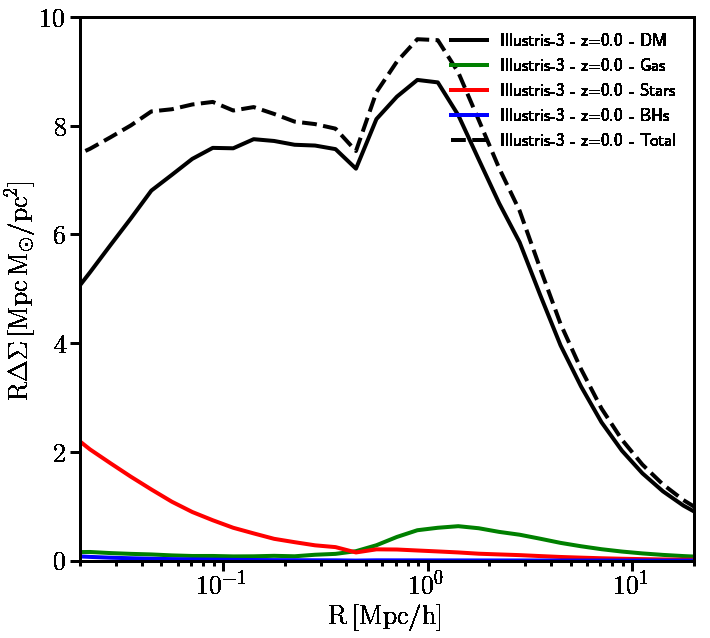

In [12]:
# Plot the profiles 

params={'backend': 'ps','text.fontsize': 28,'axes.labelsize': 28,'text.fontsize': 28,'legend.fontsize': 18,
        'xtick.labelsize': 28,'ytick.labelsize': 28,'lines.linewidth': 4,'axes.linewidth': 3,
        'xtick.major.width': 3,'ytick.major.width': 3,'xtick.minor.width': 3,'ytick.minor.width': 3,
        'xtick.major.size': 10,'ytick.major.size': 10,'xtick.minor.size': 5,'ytick.minor.size': 5,
        'lines.markeredgewidth' : 3, 'lines.markersize': 6,
        'text.usetex': True,'text.dvipnghack': True,'figure.figsize': [11,10]}
mpl.rcParams.update(params)

plt.clf()
plt.xscale('log')
plt.yscale('linear')
plt.xlabel(r'${\rm R \, [Mpc/h]}$')
plt.ylabel(r'${\rm R \Delta \Sigma \, [Mpc \,M_{\odot}/pc^2]}$')
plt.xlim([0.02,20])
plt.ylim([0,10])
plt.plot(10**prof_tot[:,0]/1e3, 10**prof_tot[:,0]/1e3*prof_tot[:,9],'k-',label=sim_name+' - z='+str(sim_z)+' - DM')
plt.plot(10**prof_tot[:,0]/1e3, 10**prof_tot[:,0]/1e3*prof_tot[:,10],'g-',label=sim_name+' - z='+str(sim_z)+' - Gas')
plt.plot(10**prof_tot[:,0]/1e3, 10**prof_tot[:,0]/1e3*prof_tot[:,11],'r-',label=sim_name+' - z='+str(sim_z)+' - Stars')
plt.plot(10**prof_tot[:,0]/1e3, 10**prof_tot[:,0]/1e3*prof_tot[:,12],'b-',label=sim_name+' - z='+str(sim_z)+' - BHs')
plt.plot(10**prof_tot[:,0]/1e3, 10**prof_tot[:,0]/1e3*(prof_tot[:,9]+prof_tot[:,10]+prof_tot[:,11]+prof_tot[:,12]),'k--',label=sim_name+' - z='+str(sim_z)+' - Total')
plt.legend(loc=1,frameon=False)
#plt.savefig('DeltaSigma.png')
plt.show()

